In [1]:
# this notebook shows that if you change how you present the data
# then the results of the network differ by serveral several orders of magnitude!

# if you let the output of the network be the timeseries instead of a single time point then the permorance is sooooooo much better

# it can even interpolate just random data 

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [3]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [4]:
def gen_test_data():
    x = np.array([[0]])
    times = np.linspace(-1, 1, 1000)[:,np.newaxis]
    y = np.cos(20*times) + np.sin(10*times)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, 20.9, size=times.shape)

    return times, x, (y + noise).T

times, x, y = gen_test_data()

In [5]:
y.shape

(1, 1000)

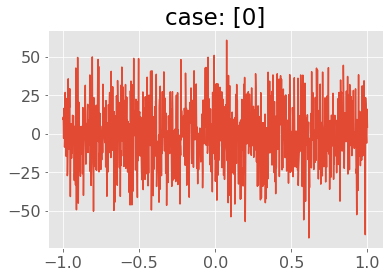

In [7]:
plt.figure()
plt.plot(times, y[0])
plt.title(f"case: {x[0]}")
plt.show()
plt.close() 

In [8]:
def build_model(input_shape, output_shape, resnet=True):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(2, activation='relu')(input_layer)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(output_shape, activation='linear')(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.nn.relu(x)
    
    if resnet:
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(2, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(x)
#         x = tf.keras.layers.ReLU()(addition)
#         output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(addition)
    else:
        x = tf.keras.layers.Dense(2, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu')(x)
        output_layer = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    model = tf.keras.Model(input_layer, output_layer)
    
    return model

In [9]:
x.shape

(1, 1)

In [10]:
y.shape

(1, 1000)

In [11]:
%%time

model_nores = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=False)

lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)
    
model_nores.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_nores = model_nores.fit(x, y, epochs=50000, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/50000 ETA: ?s,  ?epochs/s

CPU times: user 1min 16s, sys: 18.1 s, total: 1min 34s
Wall time: 50.3 s


In [12]:
%%time

model_res = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=True)


lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)

model_res.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_res = model_res.fit(x, y, epochs=50000, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/50000 ETA: ?s,  ?epochs/s

CPU times: user 1min 23s, sys: 20.1 s, total: 1min 43s
Wall time: 55.9 s


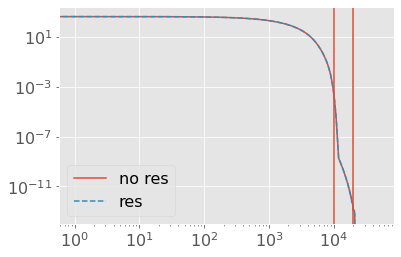

In [13]:
plt.figure()
plt.plot(history_nores.history['loss'], label='no res')
plt.plot(history_res.history['loss'], label='res', ls='--')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e4)
plt.axvline(2e4)

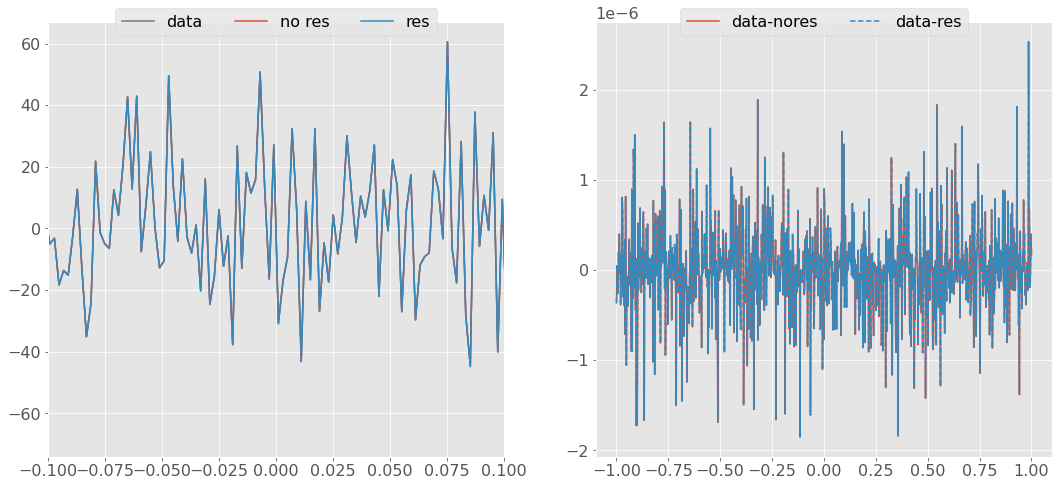

In [18]:
yhat_nores = model_nores.predict(x)[0]
yhat_res = model_res.predict(x)[0]
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[0], label='data', c='C3')
plt.plot(times, yhat_nores, label='no res', c='C0')
plt.plot(times, yhat_res, label='res', c='C1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.xlim(-0.1, 0.1)

plt.subplot(1, 2, 2)
plt.plot(times, y[0]-yhat_nores, label='data-nores', c='C0')
plt.plot(times, y[0]-yhat_res, label='data-res', c='C1', ls='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
# plt.ylim(-0.01,0.01)

In [ ]:
# model_res.summary()

In [ ]:
# model_nores.summary()

In [ ]:
# tf.keras.utils.plot_model(model_res)

In [ ]:
# tf.keras.utils.plot_model(model_nores)

# trying a linear and a non-linear sub-network

In [192]:
def build_model_sub_add(input_shape, output_shape):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    x = tf.keras.layers.Dense(128, activation='linear')(x)
    output_1 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_1')(x)
    
    
    x = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_2 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_2')(x)
    
#     x = tf.keras.layers.Dense(128, activation='tanh')(input_layer)
#     x = tf.keras.layers.Dense(128, activation='tanh')(x)
#     output_3 = tf.keras.layers.Dense(output_shape, activation='linear', name='output_3')(x)
    
#     final_output = tf.keras.layers.Add()([output_1, output_2, output_3])
    final_output = tf.keras.layers.Add()([output_1, output_2])
    
    model = tf.keras.Model(input_layer, final_output)
    
    return model

In [193]:
%%time

model_2 = build_model_sub_add(input_shape=x.shape[1], output_shape=y.shape[1])


lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)

model_2.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_2 = model_2.fit(x, y, epochs=500, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

CPU times: user 1.82 s, sys: 266 ms, total: 2.08 s
Wall time: 1.17 s


In [153]:
%%time

model_nores = build_model(input_shape=x.shape[1], output_shape=y.shape[1], resnet=False)

lr = 1e-2

if lr is None:
    boundaries = [1e4, 2e4]
    values = [1e-3, 1e-3/2, 1e-4]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    opt = tf.keras.optimizers.Adam(learning_rate_fn)
else:
    optimizer = tf.keras.optimizers.Adam(lr)
    
model_nores.compile(loss='mse', optimizer=optimizer)

callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

history_nores = model_nores.fit(x, y, epochs=50000, verbose=0, callbacks=callbacks, batch_size=10)

Training:   0%|           0/50000 ETA: ?s,  ?epochs/s

CPU times: user 1min 20s, sys: 18.5 s, total: 1min 38s
Wall time: 54.7 s


In [194]:
model_2.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_132 (Dense)               (None, 128)          256         input_34[0][0]                   
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 128)          256         input_34[0][0]                   
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 128)          16512       dense_132[0][0]                  
___________________________________________________________________________________________

In [188]:
model_nores.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 4         
_________________________________________________________________
dense_107 (Dense)            (None, 1000)              3000      
_________________________________________________________________
dense_108 (Dense)            (None, 2)                 2002      
_________________________________________________________________
dense_109 (Dense)            (None, 1000)              3000      
Total params: 8,006
Trainable params: 8,006
Non-trainable params: 0
_________________________________________________________________


In [189]:
history_2.history.keys()

dict_keys(['loss'])

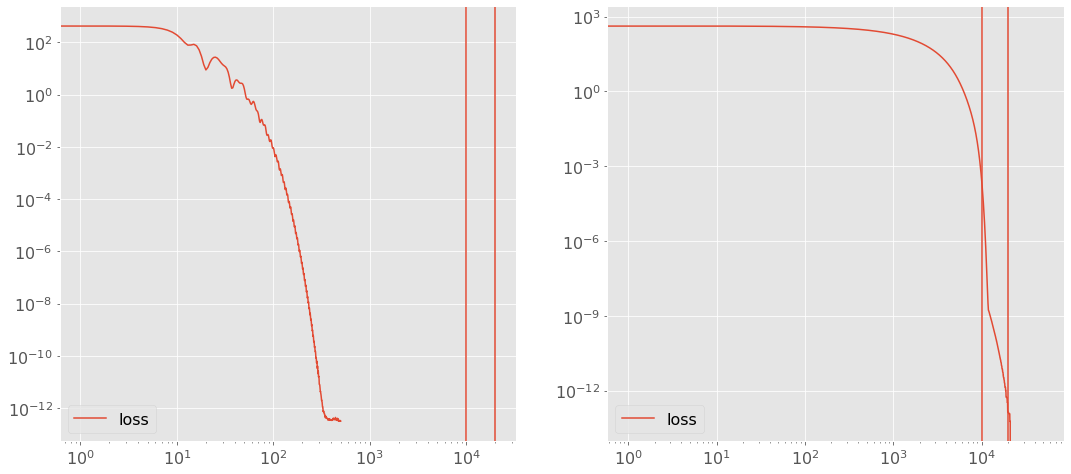

In [195]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='loss')
# plt.plot(history_2.history['output_1_loss'], label='output_1_loss')
# plt.plot(history_2.history['output_2_loss'], label='output_2_loss')
# plt.plot(history_2.history['add_17_loss'], label='add_17_loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e4)
plt.axvline(2e4)

plt.subplot(1, 2, 2)
plt.plot(history_nores.history['loss'], label='loss')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e4)
plt.axvline(2e4)

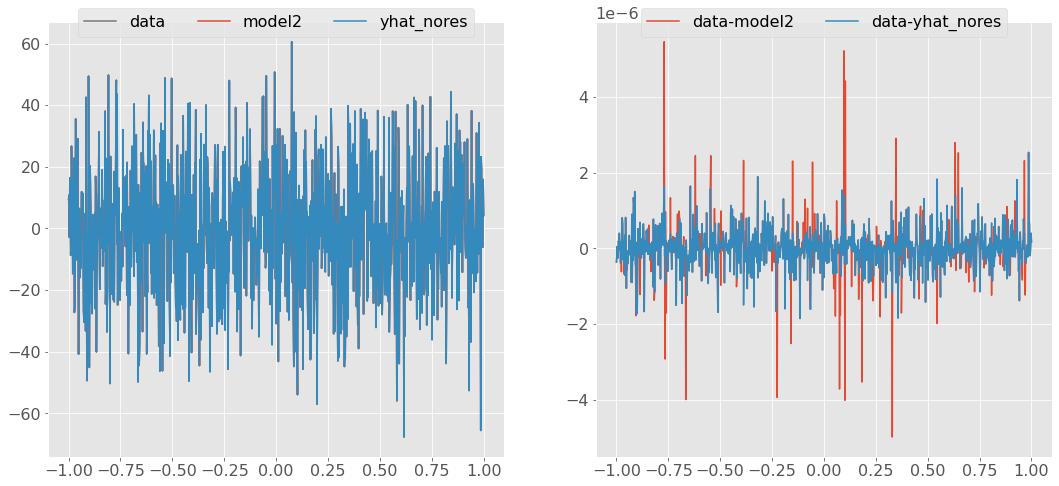

In [196]:
yhat_2 = model_2.predict(x)[0]


yhat_nores = model_nores.predict(x)[0]

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[0], label='data', c='C3')
plt.plot(times, yhat_2, label='model2', c='C0')
plt.plot(times, yhat_nores, label='yhat_nores', c='C1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
# plt.xlim(-0.1, 0.1)

plt.subplot(1, 2, 2)
plt.plot(times, y[0]-yhat_2, label='data-model2', c='C0')
plt.plot(times, y[0]-yhat_nores, label='data-yhat_nores', c='C1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
# plt.ylim(-0.01,0.01)
# plt.xlim(-0.01,0.01)